# PREDIÇÃO DE SÉRIES TEMPORIAS UTILIZANDO ALGORITMOS DO TIPO GRADIENT BOOSTING
<hr /><br />

<p>Exemplo de como utilizar algoritmos do tipo <i>Boosted Regression Trees</i> para realizar a previsão de demanda.</p>
<p>A base de dados utilizada no exemplo abaixo pode ser encontrada <a href='https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand'>clicando aqui</a>.</p>


<p>O primeiro passo que devemos executar é a importação das bibliotecas de python necessárias.</p>
<p>Caso você não possua conhecimento sobre essas bibliotecas não se preocupe, seu uso será exemplificado abaixo.</p>

In [1]:
# Importando as bibliotecas necessárias
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configurando atributos padrão para as bibliotecas 
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
sns.set_context("talk")
np.random.seed(42)

## Importação e visualização dos dados
<hr /><br />

<p>Agora devemos usar as bibliotecas importadas para executar a leitura dos dados.</p>
<p>Posteriormente usaremos outras dessas bibliotecas para plotar gráficos que nos ajudem a compreender mais o comportamento dos dados.</p>

In [2]:
# Lendo os dados presentes em um arquivo CSV
df = pd.read_csv('SeoulBikeData.csv', encoding='latin-1', parse_dates=['Date'])

# Renomeando colunas do dataset para facilitar o uso
df.columns = ['date', 'rent_count', 'hour', 'temp', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
              'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

# Ordenando os dados de acordo com os campos 'date' e 'hour'
df.sort_values(by=['date', 'hour'], inplace=True)

# Exibindo os primeiros registros 
print(df.shape)
df.head()

(8760, 14)


,date,rent_count,hour,temp,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,season,holiday,functioning_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


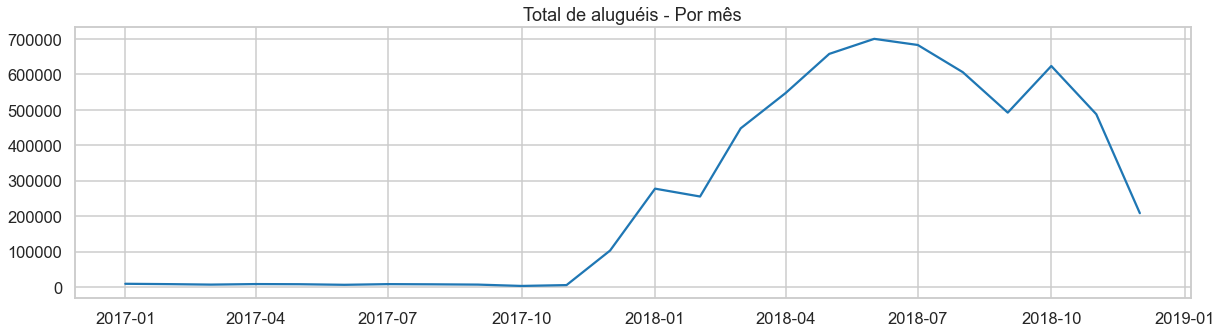

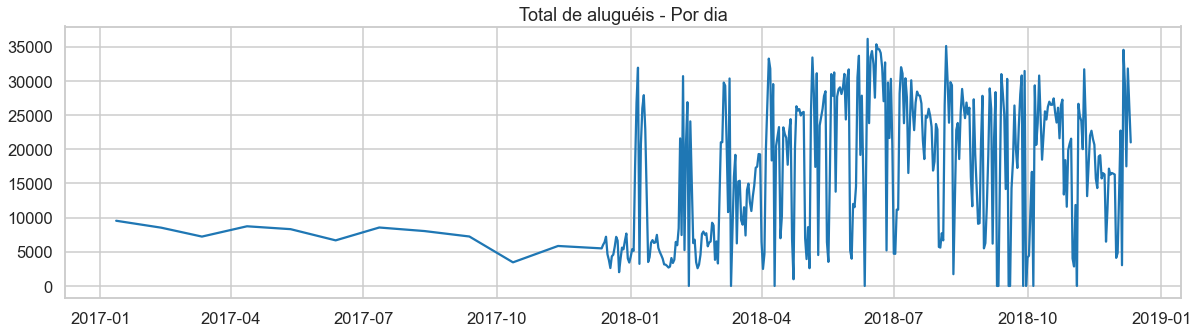

In [3]:
# Gerando variáveis utilizadas na agregação dos dados
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['year_month'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m')

# Agrupando os dados por mês/ano
df_plot = df.groupby('year_month')['rent_count'].sum().reset_index()

# Gerando gráfico com aluguéis de bikes agregadas por mês/ano
fig = plt.figure(figsize = (20,5))
plt.plot(df_plot.year_month, df_plot.rent_count)
plt.title('Total de aluguéis - Por mês')
plt.show()

# Agrupando as dados por dia
df_plot = df.groupby('date')['rent_count'].sum().reset_index()

# Gerando gráfico com aluguéis de bikes agregadas por dia
fig = plt.figure(figsize = (20,5))
plt.plot(df_plot.date, df_plot.rent_count)
plt.title('Total de aluguéis - Por dia')
plt.show()

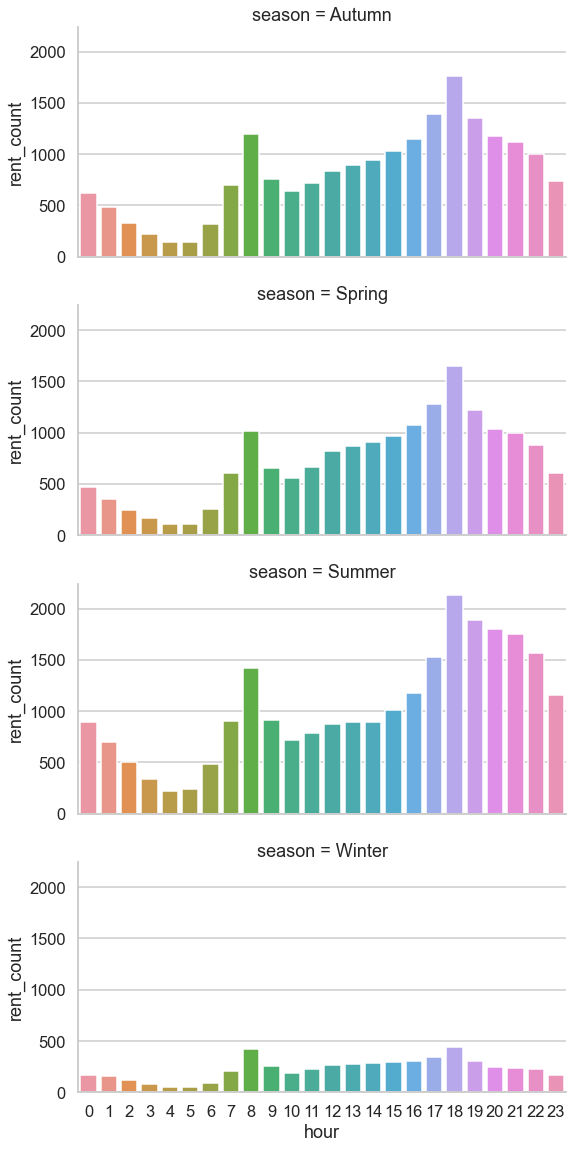

In [4]:
# Agrupando dados de acordo com o número de aluguéis médios por hora para cada estação do ano
df_plot = df.groupby(['season', 'hour'])['rent_count'].mean().reset_index()

# Gerando gráficos das distribuições dos aluguéis médios por hora de acordo com a estação
sns.catplot(x="hour", y="rent_count", row="season", data=df_plot, kind="bar", height=4, aspect=2)
plt.show()

Podemos notar que o número de aluguéis tem uma grande variabilidade ao longo dos dias, apresentando padrões diferentes de acordo com a estação do ano.

Podemos notar ainda um grande crescimento no número total de aluguéis entre os anos de 2017 e 2018.

## Criando variáveis preditoras (features do modelo)
<hr /><br />

<p>Para realizar uma predição é importante selecionar variáveis que descrevam bem a variável predita.</p>

<p>No caso das séries temporais, como é o caso dos problemas de previsão de demanda, dois tipos de variáveis são amplamente utilizadas: os lags temporais e as variáveis de janela rolante.</p>

<p>Os lags são os valores da variável target, porém em períodos anteriores. Geralmente são altamente correlacionados com os valores a serem preditos. Técnicas como a <b>função de autocorrelação</b> podem ser utilizadas para definir o número de lags ideal para a construção do modelo.</p>

<p>Já as variáveis de janela rolante são estatísticas descritivas feitas sobre janelas de tempo no passado. Podemos utilizar como exemplo de janela rolante o cálculo das <b>médias móveis</b>. Outra estatística interessante na construção desse tipo de variável é o <b>desvio padrão</b>.</p>

<p>Por fim podemos incluir variáveis que indiquem a sazonalidade presente nos dados. Variáveis como horas, dia da semana, mês, trimestre, etc podem nos ajudar nossos modelos a predizer melhor o resultado.</p>

<p>Um modo interessante de potencializar o poder preditor das variáveis sazonais é através do <a href='https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/'>encoading circular</a>, que nos permite representar melhor a característica cíclica dos dados.</p>


In [5]:
# Função que cria variáveis do tipo lag temporal
def create_lag_features(df: pd.DataFrame, target: str, lags: list, prefix="") -> pd.DataFrame:
    for lag in lags:
        df[prefix + f"lag_{lag}"] = df[target].shift(lag).values

    return df

# Função que cria variáveis do tipo janela rolante
def create_rolling_features(df: pd.DataFrame, target: str, rolling_windows: list, rolling_agg: list, prefix="") -> pd.DataFrame:
    for window in rolling_windows:
        for agg in rolling_agg:
            df[prefix + f"r{agg}_1_{window}"] = df[target].shift(1).rolling(window).mean().values

    return df

# Criando lags temporais para 1, 6, 12, 24 e 48 horas
df = create_lag_features(df, 'rent_count', [1, 6, 12, 24, 48])

# Calculando o desvio padrão nas últimas 24 horas
df = create_rolling_features(df, 'rent_count', [12, 24], rolling_agg=['std'])

# Criando as médias móveis das últimas 4, 6, 12, 24, 48 horas
df = create_rolling_features(df, 'rent_count', [4, 6, 12, 24, 48], rolling_agg=['mean'])

# Encoading circular das horas
df["hour_cos"] = np.cos(df["hour"] * 2 * np.pi / 24).astype("float16")
df["hour_sin"] = np.sin(df["hour"] * 2 * np.pi / 24).astype("float16")   

# Removendo os itens para os quais não foi possível criar as variáveis preditoras
df.dropna(inplace=True)

# Imprimindo o nome de todas as colunas
df.columns

Index(['date', 'rent_count', 'hour', 'temp', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'season', 'holiday', 'functioning_day', 'year', 'month',
       'year_month', 'lag_1', 'lag_6', 'lag_12', 'lag_24', 'lag_48',
       'rstd_1_12', 'rstd_1_24', 'rmean_1_4', 'rmean_1_6', 'rmean_1_12',
       'rmean_1_24', 'rmean_1_48', 'hour_cos', 'hour_sin'],
      dtype='object')

## Verificando correlação
<hr /><br/>

<p>Por fim vamos verificar a correlação entre as variáveis preditoras criadas e o target do modelo. Para isso utilizaremos o heatmap.</p>

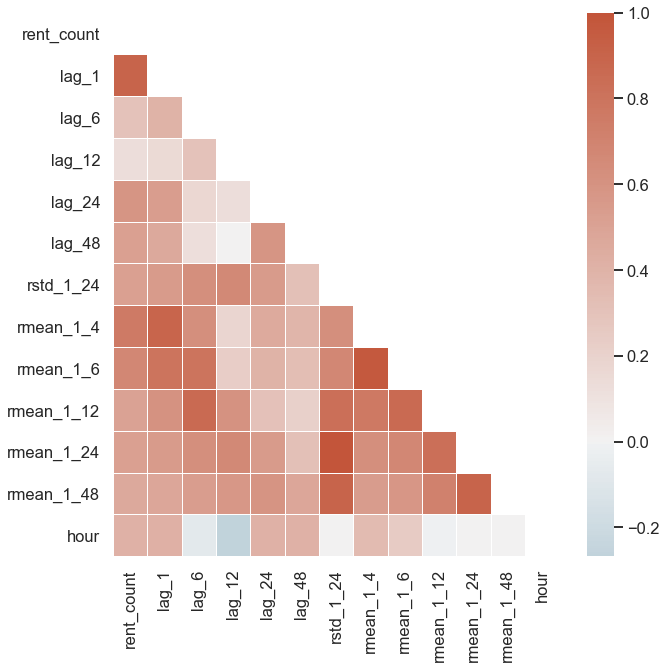

In [6]:
# Lista de variáveis para as quais a correlação será calculada
vars = ['rent_count', 'lag_1', 'lag_6', 'lag_12', 'lag_24', 'lag_48', 'rstd_1_24', 'rmean_1_4', 'rmean_1_6', 'rmean_1_12', 'rmean_1_24', 'rmean_1_48', 
        'hour', 'season', 'holiday', 'functioning_day']

# Calculando a correlação entre as variáveis preditoras e o target da previsão
corr = df[vars].corr()

# Criando uma máscara 
mask = np.triu(np.ones_like(corr, dtype=bool))

# Criando uma paleta de cores
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plotando gráfico das correlações
fig = plt.figure(figsize = (10,10))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.show()

In [7]:
features = ['lag_1', 'lag_6', 'lag_12', 'lag_24', 'lag_48', 'rstd_1_24', 
            'rmean_1_4', 'rmean_1_6', 'rmean_1_12', 'rmean_1_24', 'rmean_1_48', 
            'hour_cos', 'hour_sin', 'season', 'holiday', 'functioning_day']
            
cat_features = ['season', 'holiday', 'functioning_day']

for c in cat_features:
    df[c] = df[c].astype('category')

X_train, X_test, y_train, y_test = train_test_split(df[features], df.rent_count, test_size=0.33, random_state=42, shuffle=False)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
valid_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)

booster_params = {
    "objective": "poisson",
    "learning_rate": 0.01,
    "random_state": 42,
    "n_jobs": -1,
    "num_iterations": 3000
}
 
booster = lgb.train(booster_params, train_data, valid_sets=[train_data, valid_data], verbose_eval=300, early_stopping_rounds=100)
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 5837, number of used features: 16
[LightGBM] [Info] Start training from score 6.506831
Training until validation scores don't improve for 100 rounds
[300]	training's poisson: -3940.8	valid_1's poisson: -4652.87
[600]	training's poisson: -3963.42	valid_1's poisson: -4674.54
[900]	training's poisson: -3967.34	valid_1's poisson: -4677.68
[1200]	training's poisson: -3968.71	valid_1's poisson: -4678.49
[1500]	training's poisson: -3969.66	valid_1's poisson: -4678.89
[1800]	training's poisson: -3970.28	valid_1's poisson: -4679.01
[2100]	training's poisson: -3970.77	valid_1's poisson: -4679.05
[2400]	training's poisson: -3971.18	valid_1's poisson: -4679.15
[2700]	training's poisson: -3971.53	valid_1's poisson: -4679.22
[3000]	training's pois

In [8]:
def print_metrics(y_true, y_pred):

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mean = float(y_true.mean())
   
    print('Média target:', round(mean, 2))
    print('MAE:', round(mean_absolute_error(y_true, y_pred), 2))
    print('RMSE:', rmse.round(2))
    print('NRMSE:', round(rmse / mean, 4))
    print('R2:', round(r2_score(y_true, y_pred), 4))

print('Treino:')
pred = np.ceil( booster.predict(X_train) )
print_metrics(y_train, pred)

print('\nTeste:')
pred = np.ceil( booster.predict(X_test) )
print_metrics(y_test, pred)

Treino:
Média target: 669.7
MAE: 42.61
RMSE: 74.73
NRMSE: 0.1116
R2: 0.9867

Teste:
Média target: 780.94
MAE: 80.19
RMSE: 134.9
NRMSE: 0.1727
R2: 0.9549


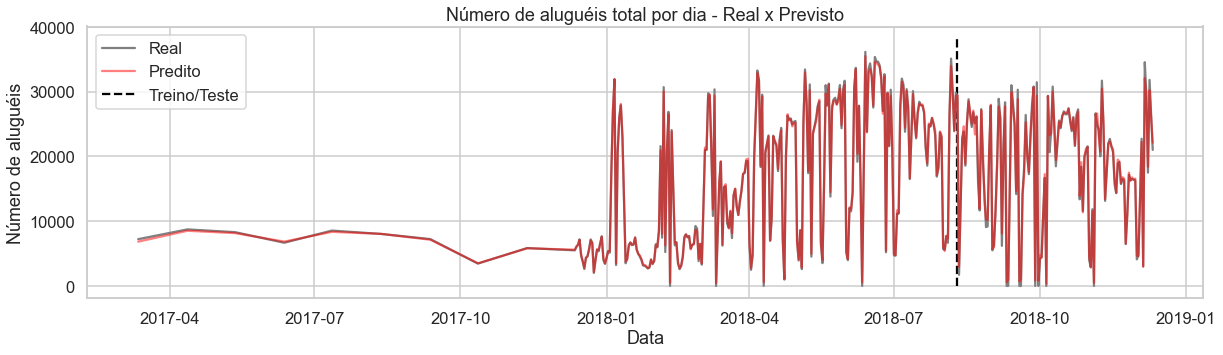

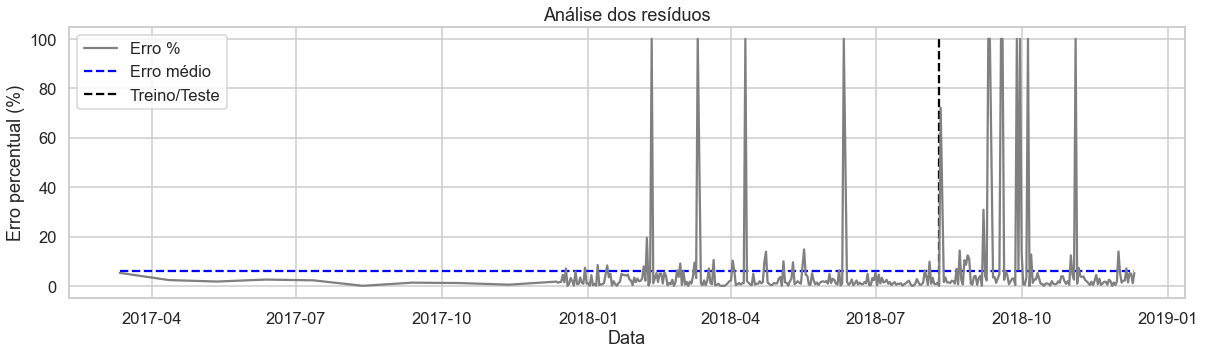

Erro médio: 6.09 %
Erro geral: 0.13 %


In [13]:
df['pred'] = booster.predict(df[features])
df_plot = df.groupby('date')['rent_count', 'pred'].sum().reset_index()

df_plot['erro'] = (np.abs(df_plot['pred'] - df_plot['rent_count']) / df_plot['rent_count']) * 100
df_plot['erro'] = np.where(df_plot['rent_count'] == 0, 100, df_plot['erro'])

# Gráfico real x predito
fig = plt.figure(figsize = (20,5))
plt.plot(df_plot.date, df_plot.rent_count, color='gray', label='Real')
plt.plot(df_plot.date, df_plot.pred, color='red', label='Predito', alpha=.5)
plt.vlines(df.loc[X_train.index, 'date'].max(), df_plot.rent_count.min(), df_plot.rent_count.max() + 2000, color='black', label='Treino/Teste', linestyles='dashed')

plt.title('Número de aluguéis total por dia - Real x Previsto')
plt.ylabel('Número de aluguéis')
plt.xlabel('Data')
plt.legend()
plt.show()

# Gráfico de residuos
fig = plt.figure(figsize = (20,5))
plt.plot(df_plot.date, df_plot.erro, color='gray', label='Erro %')
plt.hlines(df_plot['erro'].mean(), df_plot.date.min(), df_plot.date.max(), color='blue', label='Erro médio', linestyles='dashed')
plt.vlines(df.loc[X_train.index, 'date'].max(), df_plot.erro.min(), df_plot.erro.max(), color='black', label='Treino/Teste', linestyles='dashed')
plt.title('Análise dos resíduos')
plt.ylabel('Erro percentual (%)')
plt.xlabel('Data')
plt.legend()
plt.show()

total_pred = df_plot['pred'].sum()
total_real = df_plot['rent_count'].sum()
total_error = abs(total_real - total_pred) / total_real
print('Erro médio:', round(df_plot['erro'].mean(), 2), '%')
print('Erro geral:', round(total_error * 100, 2), '%')